# Main Section

## Overview
The scope of this script is to prepare, organise and visualise spatial data of wine producers of Douro region located in Portugal. In the following steps weather data will be used to analyses the impact of climate change on the whole wine production of the region and on the single grapes used in the area.

## 1. Load packages/modules

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import geopy.geocoders
import rasterio as rio
import glob as glb
import os

from cartopy.feature import ShapelyFeature
from shapely.geometry import Point, box
from functools import partial
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import GoogleV3
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.mask import mask
from fiona.crs import from_epsg
from random import randint

%matplotlib notebook

# paths
douro_path = "./data_source/douro/"  # path to load Douro datasets
alentejio = "./data_source/alentejo/" # path to load Alentejio datasets

## 2. Methods section

In [2]:
def addressGeocoded(df,gc):
    '''
    This function accepts a dataframe and a geocode object and returns a geo dataframe
    
    :param df: dataframe with addresses
    :param gc: geocode object
    
    :returns geodataframe
    '''
    tmp_df = df.copy() # create a copy of the original dataframe, in this way no changes will be applied to the original one
    tmp_df['geolocation'] = tmp_df['address'].apply(gc) # translate address into coordinate
    tmp_df['geometry'] = tmp_df['geolocation'].apply(lambda loc: tuple(loc.point[0:2]) if loc else None) #extract tuple point location
    tmp_df['geometry'] = tmp_df['geometry'].apply(Point) # convert tuple in shapely geometry point
    gdf = gpd.GeoDataFrame(tmp_df)
    gdf.set_crs("EPSG:3763", inplace=True) #Set the projection to the ETRS89/PT-TMS09
    gdf = gdf.drop(columns=['geolocation']) #Drop geolocation information; shapefile only accept one geometry column when saving the geodataframe
    gdf.to_file("./data_source/douro/douro_wine_producers.shp") # save the geodataframe in shape file; in this way no queries are sent to Google geocoding service
    return gdf

def imgDisplay(image, ax, bands, stretch_args=None, **imshow_args):
    '''
    This method reorganise the structure of the raster image
    
    :param image: raster image
    :param ax: fig object
    :param bands: bands of the raster image
    
    :returns the axes and the image
    '''
    dispimg = img.copy().astype(np.float32)  # make a copy of the original image,
    # but be sure to cast it as a floating-point image, rather than an integer

    for b in range(img.shape[0]):  # loop over each band, stretching using percentile_stretch()
        if stretch_args is None:  # if stretch_args is None, use the default values for percentile_stretch
            dispimg[b] = percentile_stretch(img[b])
        else:
            dispimg[b] = percentileStretch(img[b], **stretch_args)

    # next, we transpose the image to re-order the indices
    dispimg = dispimg.transpose([1, 2, 0])

    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], **imshow_args)

    return handle, ax

def generateHandles(labels, colors, edge='k', alpha=1):
    '''
    generate_handles help to build the legend for the features used in the map
    :param color: color list
    
    :returns handle object
    '''
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

def colorListCreation(object_list,hexcolor=0xFFFFFF):
    '''
    This methods create a random list of colors according
    to the size of the list of objects need to be colored
    
    :param object_list: object need to be associated with a color
    :param hexcolor: color in hex; the dault value is white
    
    :returns color_list
    '''
    colors = []
    for i in range(len(object_list)):
        colors.append('#%06X' % randint(0, hexcolor))
    return colors

def getFeatures(gdf):
    '''
    Function to parse features from GeoDataFrame in such a manner that rasterio wants them
    
    :param gdf: geodataframe
    
    :returns json format
    '''
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

def percentileStretch(img, pmin=0., pmax=100.):
    '''
    This is where you should write a docstring.
    '''
    # here, we make sure that pmin < pmax, and that they are between 0, 100
    if not 0 <= pmin < pmax <= 100:
        raise ValueError('0 <= pmin < pmax <= 100')
    # here, we make sure that the image is only 2-dimensional
    if not img.ndim == 2:
        raise ValueError('Image can only have two dimensions (row, column)')

    minval = np.percentile(img, pmin)
    maxval = np.percentile(img, pmax)

    stretched = (img - minval) / (maxval - minval)  # stretch the image to 0, 1
    stretched[img < minval] = 0  # set anything less than minval to the new minimum, 0.
    stretched[img > maxval] = 1  # set anything greater than maxval to the new maximum, 1.

    return stretched

## 3. Load the data

Portugal municipalities and parishes are loaded from the shapefile *Cont_AAD_CAOP2020*; source [**DgTerritorio**](https://www.dgterritorio.gov.pt/cartografia/cartografia-tematica/caop?language=en) and load Douro municipalities and parishes dataset reporting the informtion where the douro wine is produced; source [**IVV**](https://www.ivv.gov.pt/np4/%7B$clientServletPath%7D/?newsId=1736&fileName=IVV_WEB_TB.PDF)

In [4]:
# Laod Portugal municipalities.
pt_municipalities_gdf = gpd.read_file("./data_source/Cont_AAD_CAOP2020/Cont_AAD_CAOP2020.shp")
# pt_municipalities_gdf.shape
pt_municipalities_gdf.head(15)

,Dicofre,Freguesia,Concelho,Distrito,TAA,Area_T_ha,Area_EA_ha,Des_Simpli,geometry
0,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.91,0.04,Sagres,"POLYGON ((-69674.530 -294276.294, -69681.011 -..."
1,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.91,0.17,Sagres,"POLYGON ((-69645.821 -294240.694, -69657.401 -..."
2,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.91,0.20,Sagres,"POLYGON ((-69720.371 -294162.995, -69715.271 -..."
3,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.91,0.09,Sagres,"POLYGON ((-70031.961 -294143.877, -70041.691 -..."
4,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.91,0.39,Sagres,"POLYGON ((-69800.002 -294108.296, -69796.762 -..."
5,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.91,0.03,Sagres,"POLYGON ((-70020.851 -294082.657, -70015.761 -..."
6,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.91,1.22,Sagres,"POLYGON ((-69899.552 -294063.147, -69895.842 -..."
7,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.91,0.09,Sagres,"POLYGON ((-69752.313 -293969.775, -69752.313 -..."
8,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.91,0.02,Sagres,"POLYGON ((-75949.121 -293801.236, -75953.111 -..."
9,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.91,0.04,Sagres,"POLYGON ((-69518.586 -293655.964, -69527.976 -..."


In [5]:
# Load Douro municipalities and parishes dataset where douro wine is produced.
douro_municipalities_df = pd.read_excel(douro_path+"douro_municipality_parish.xlsx")
douro_municipalities_df.shape
douro_municipalities_df.head(15)

,Area Geografica,Concelhos,Frequesias
0,Baxio Corgo,Mesão Frio,NaN
1,Baxio Corgo,Peso da Régua,NaN
2,Baxio Corgo,Santa Marta de Penaguião,NaN
3,Baxio Corgo,Vila Real,Abaças
4,Baxio Corgo,Vila Real,Ermida
5,Baxio Corgo,Vila Real,Folhadela
6,Baxio Corgo,Vila Real,Guiães
7,Baxio Corgo,Vila Real,Mateus
8,Baxio Corgo,Vila Real,Nogueira
9,Baxio Corgo,Vila Real,Parada de Cunhos


In [6]:
# Get the list of unique Douro municipalities
unique_munic = list(douro_municipalities_df['Concelhos'].unique()) #List of unique municipalities
pt_douro_munic_gdf = pt_municipalities_gdf[pt_municipalities_gdf['Concelho'].apply(lambda muni: muni in unique_munic)] #extract Douro municipalities from Portugal dataset
#
# Get the list of unique Douro parishes
# Substitute the NaN value for the parsih with the corresponding municipality. 
#for i in range(len(douro_municipalities_df.index)):
 #   if pd.isna(douro_municipalities_df.iloc[i,2]):
  #      douro_municipalities_df.iloc[i,2] = douro_municipalities_df.iloc[i,1]
#douro_municipalities_df
#unique_parishes = douro_municipalities_df['Frequesias'].unique() #List of parishes
#pt_douro_parishes_gdf = pt_municipalities_gdf[pt_municipalities_gdf['Freguesia'].apply(lambda fregu: fregu in unique_parishes)] #extract Douro parishes from Portugal dataset

In [7]:
pt_douro_munic_gdf.head() #Check the dataframe

,Dicofre,Freguesia,Concelho,Distrito,TAA,Area_T_ha,Area_EA_ha,Des_Simpli,geometry
214,090410,Mata de Lobos,Figueira de Castelo Rodrigo,Guarda,ÁREA PRINCIPAL,3697.29,3697.29,Mata de Lobos,"POLYGON ((108183.030 137946.011, 107387.875 13..."
229,090918,Prova e Casteição,Mêda,Guarda,ÁREA PRINCIPAL,2602.61,2602.61,Prova e Casteição,"POLYGON ((69087.504 144866.380, 69070.975 1448..."
660,090406,Escalhão,Figueira de Castelo Rodrigo,Guarda,ÁREA PRINCIPAL,7880.74,7880.74,Escalhão,"POLYGON ((100800.954 151822.754, 100845.704 15..."
661,180511,Lazarim,Lamego,Viseu,ÁREA PRINCIPAL,1653.84,1653.84,Lazarim,"POLYGON ((25364.680 151852.479, 25377.150 1518..."
663,091401,Almendra,Vila Nova de Foz Côa,Guarda,ÁREA PRINCIPAL,5440.65,5440.65,Almendra,"POLYGON ((95730.137 152175.506, 95762.159 1520..."


In [ ]:
# Check all the douro wine production municipalities are in the new sub geodataframe 
print(pt_douro_munic_gdf['Concelho'].unique().shape)
print(unique_munic.shape)
test_list = []
for element in unique_munic:
    if element not in pt_douro_munic_gdf['Concelho'].unique():
        test_list.append(element)
print(test_list)
pt_municipalities_gdf[pt_municipalities_gdf['Freguesia']=='Escalhão']

In [8]:
# Check Google geocoding API service access in Appendix to see how the geodatframe has been obtained
douro_wine_producers_gdf = gpd.read_file("./data_source/douro/douro_wine_producers.shp")
unique_producer = list(douro_wine_producers_gdf['producer'].unique()) #Create a list of unique Douro wine producers
douro_wine_producers_gdf.head(10)

,producer,address,geometry
0,Niepoort,"670 Rua Candido do Reis, Vila Nova de Gaia 4400",POINT (41.13104 -8.61094)
1,Poeira,"Provesende 5060, Villa Real",POINT (41.21715 -7.56667)
2,Quinta do Couquinho,"Horta da Vilarica, 5160-101 Torre de Moncorvo,...",POINT (41.23191 -7.12256)
3,Quinta do Judeu,"Estrada EM313, Peso da Regua 5050, Vila Real",POINT (41.17185 -7.73081)
4,Quinta do Pego,"Estrada Nacional 222, 5120-493 Valenca do Dour...",POINT (41.15907 -7.55528)
5,Quinta Dos Castelares,"Avenida Guerra Junqueiro, 5180-104 Freixo de E...",POINT (41.08775 -6.80785)
6,1912winemakers,Av. Dr. Antunes Guimarães 255/277 4100 - 079 P...,POINT (41.16581 -8.66137)
7,Abraco,"Rua do Liboso 286, 4510-076 Jovim, Porto",POINT (41.11999 -8.50855)
8,A Brites Aguiar,"5130-520 Varzea de Trevoes, Sao Joao da Pesque...",POINT (41.09717 -7.45998)
9,Adega Aromatica,"Rua da Igreja, Seara, 5130-070 Ervedosa do Dou...",POINT (41.16642 -7.47293)


In [9]:
### Load Douro Region shapefile
douro_gdf = gpd.read_file(douro_path+"RDD_ETRS89/RDD_ETRS89.shp")
print(douro_gdf.crs)
dxmin, dymin, dxmax, dymax = douro_gdf.total_bounds #total_bounds gives output the xmin, ymin, xmax, ymax of the area

epsg:4258


## 4. Create a map of Douro using vector data
Cartopy and Matplotlib are used to display the data; The first *fig* object that needs to be created in order to be used as container for the data

<IPython.core.display.Javascript object>


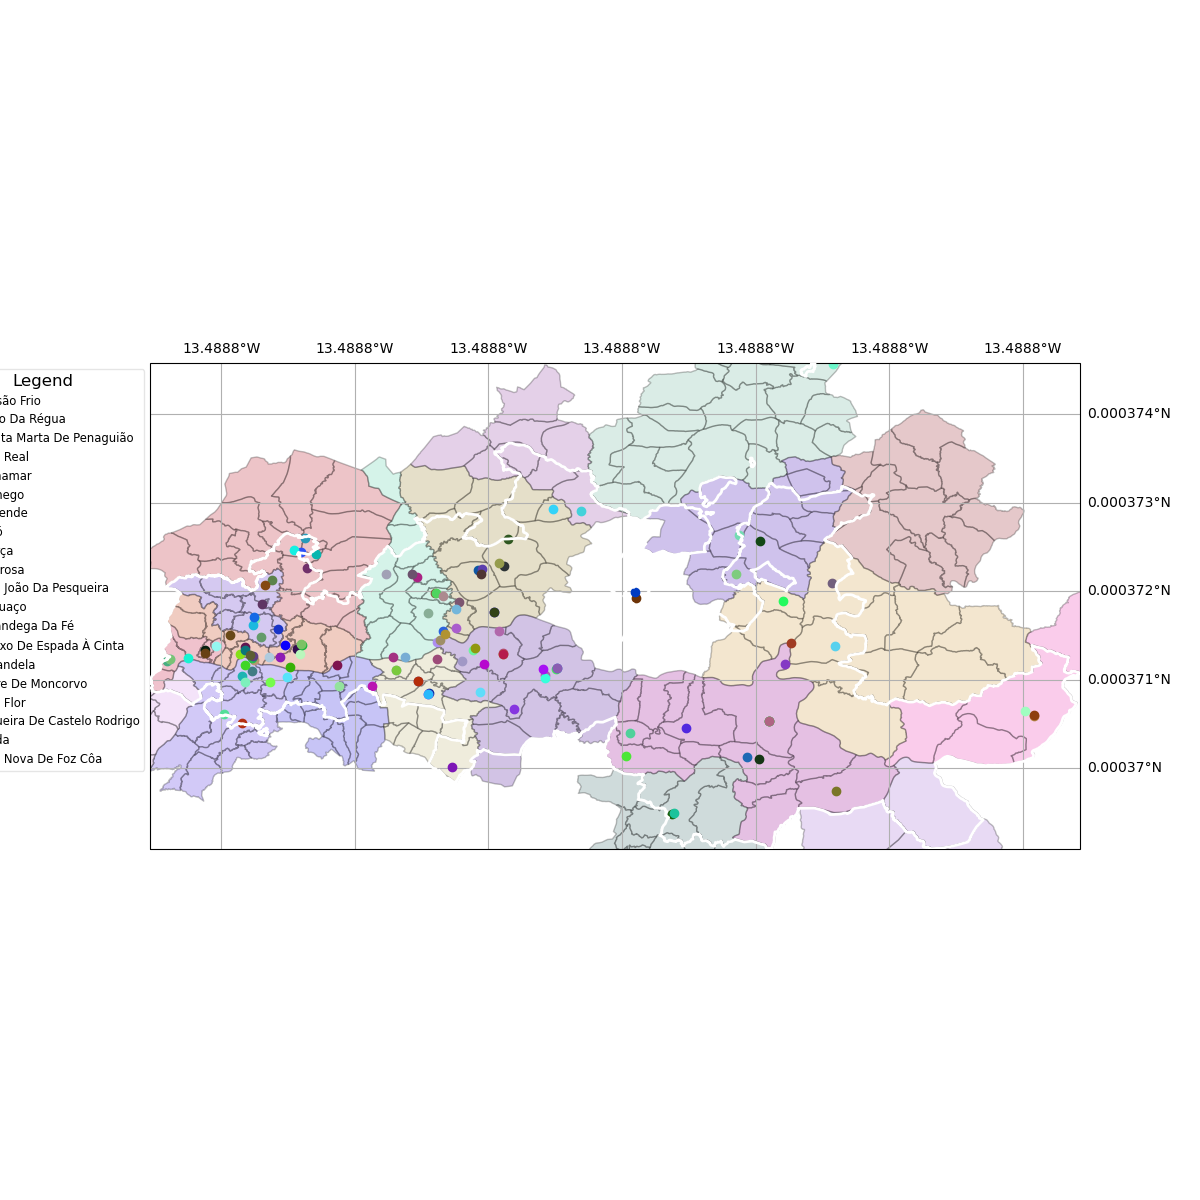

In [10]:
# Create the figure layout
pt_crs = ccrs.UTM(29) #Universal Trasverse Marcator system for Portugal
dfig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=pt_crs))
ax = plt.axes(projection=ccrs.Mercator()) # create axes object with Maractor projection
douro_region = ShapelyFeature(douro_gdf['geometry'], pt_crs, edgecolor='w',linewidth=2,facecolor='none',zorder=3)
ax.add_feature(douro_region)# add the douro region borders
#
gridlines = ax.gridlines(draw_labels=True)
gridlines.left_labels = False
gridlines.bottom_labels = False
# Douro's boundaries are used to zoom the map to our area of interest
ax.set_extent([dxmin, dxmax, dymin, dymax], crs=pt_crs) #set_extent allow to zoom in the area of interest

### Add Features
Bofore adding features such as point location, other type of data, it's worth to compare the CRS in the loaded dataset and change the projection where is needed
#### Municipalities & wine producers geolocation

In [ ]:
pt_douro_munic_gdf.crs # pt_douro_parish_gdf has the same CRS

The Portugal municipality shapefile uses EPSG:3763 that it's a prjection; this are geometric coordinates. The fib object uses geographic coordinates. The Douro municipalities shapefile needs to be converted before being plotted

In [11]:
munic_colors = colorListCreation(unique_munic) #List of colors for the municipalities
producer_colors = colorListCreation(unique_producer,0xbad0de) #List of colors for the producers

In [12]:
pt_douro_munic_wgs84 = pt_douro_munic_gdf.to_crs("EPSG:4326") # Conversion from Cartesian to Geographic coordinates
for i, name in enumerate(unique_munic):
    douro_municip = ShapelyFeature(pt_douro_munic_wgs84['geometry'][pt_douro_munic_wgs84['Concelho']==name],
                                   pt_crs, 
                                   edgecolor='k',
                                   facecolor=munic_colors[i],  # use munic_colors[i] if no raster map is used in the background
                                   linewidth=1,
                                   alpha=0.25
                                  )
    ax.add_feature(douro_municip)# add the douro region borders
for i,color in enumerate(unique_producer):
    ax.plot(douro_wine_producers_gdf.iloc[i,2].y,douro_wine_producers_gdf.iloc[i,2].x,'o',color=producer_colors[i],transform=pt_crs)
# generate a list of handles for the county datasets
municipality_handles = generateHandles(unique_munic, munic_colors, alpha=0.25)
# update county_names to take it out of uppercase text
munici_names = [name.title() for name in unique_munic]

leg = ax.legend(municipality_handles, munici_names, title='Legend', title_fontsize=12, fontsize='small', loc='upper right', bbox_to_anchor=(0.,1.), frameon=True, framealpha=0.5)
#dfig
#Save the file
#dfig.savefig("./img/douromap_with_producers_and_municipalities.png", dpi=300, bbox_inches='tight')

## 5 Add Douro raster map
Check `Build Douro raster map` in Appendix to see how the raster map has been obtained

### 5.1 Clip raster data using Douro dimensions
The satelite image cover a bigger area; in order to work on Douro area, the image needs to be clip using Douro bounds.
Note: The following section can be skip, the reduced raster map is already provided in section 5.2

In [ ]:
# Load satelite image of Douro area
with rio.open(douro_path+"Sat_images/Douro_region_Mosaic.tif") as dataset:
    img = dataset.read()
    xmin, ymin, xmax, ymax = dataset.bounds
    print(dataset.bounds) # print area dimension
    print(dataset.crs) # print projection 
    print(img)
    print(img.shape) # print pixel inforamtion

#xmin, ymin, xmax, ymax = douro_gdf.total_bounds
#bbox = box(xmin, ymin, xmax, ymax)
#print(bbox)

In [ ]:
bbox = box(dxmin, dymin, dxmax, dymax) #Create a box area with the Douro dimension area
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0],crs="4258") #Create a geodataframe adding the geometry and defining the same Doure CRS
print(dataset.meta)
geo = geo.to_crs(crs=dataset.crs) # Use the same CRS from raster image

In [ ]:
# Display raster
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=pt_crs))
coords = getFeatures(geo)

In [ ]:
dataset = rio.open(douro_path+"Sat_images/Douro_region_Mosaic.tif")
out_img, out_transform = mask(dataset, shapes=coords, crop=True)
out_img.shape[1]
out_meta = dataset.meta.copy()
print(out_meta)
 out_meta.update({"driver": "GTiff",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform
                 }
                )
with rio.open(douro_path+"Sat_images/Douro_region_Mosaic_reduced.tif", "w", **out_meta) as dest:
    dest.write(out_img)
    dest.close()

### 5.2 Display raster data

In [13]:
with rio.open(douro_path+"Sat_images/Douro_region_Mosaic_reduced.tif") as dataset:
    img = dataset.read()
    xmin, ymin, xmax, ymax = dataset.bounds
    print(dataset.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 3299, 'height': 2313, 'count': 3, 'crs': CRS.from_epsg(32629), 'transform': Affine(30.0, 0.0, 590475.0,
       0.0, -30.0, 4600035.0)}


<IPython.core.display.Javascript object>


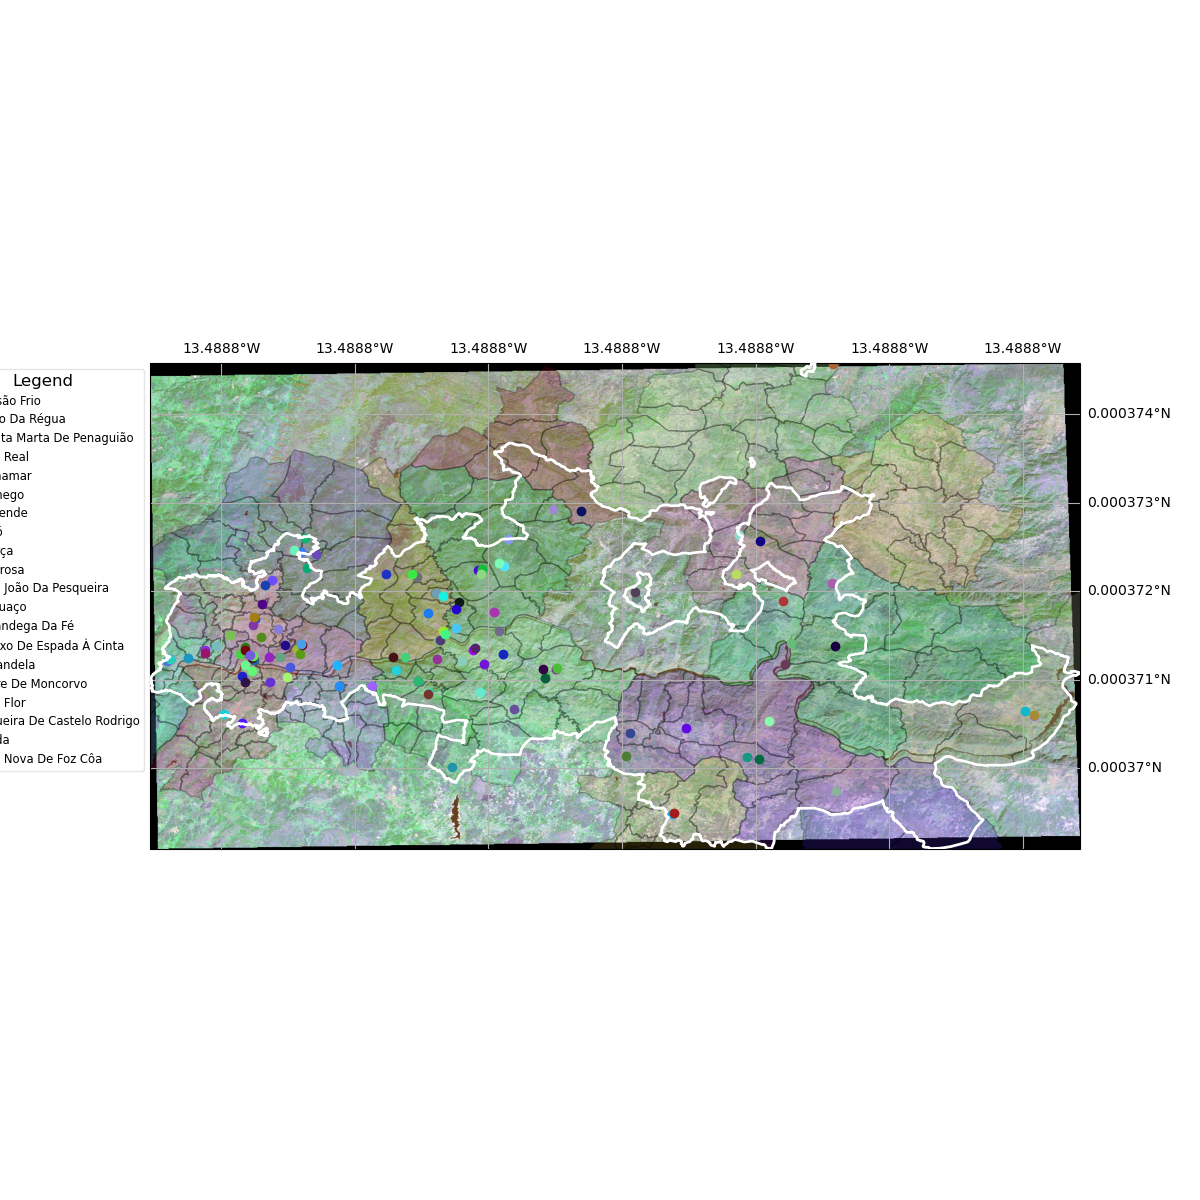

In [14]:
my_kwargs = {'extent': [dxmin, dxmax, dymin, dymax],
             'transform': pt_crs}

my_stretch = {'pmin': 0.1, 'pmax': 99.9}
h, ax = imgDisplay(img, ax, [2, 1, 0],stretch_args=my_stretch, **my_kwargs)
dfig

# Appendix

## A) Google geocoding API service access
This cell can be run only once to geocode wine producers' addresses.
The file is then saved on the harddisk.
Google account with API key is needed in order to operate

In [ ]:
### Load Douro wine producers dataset
douro_wine_producers_df = pd.read_excel(douro_path+"douro_wine_producers_list.xlsx")
#douro_wine_producers_df.head()

#Instance Google connection for geocoding
geopy.geocoders.options.default_user_agent = 'wine_app'
geopy.geocoders.options.default_scheme = 'https'
with open("./data_source/apikey.txt") as f:   #load Google API key
    apikey = f.readline()
    f.close
geolocator = GoogleV3(api_key=apikey)
geocode = partial(geolocator.geocode, language="en")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=5)
# Query Google
douro_wine_producers_gdf = addressGeocoded(douro_wine_producers_df,geocode)
douro_wine_producers_gdf.head()

## B) Build Douro raster map
In the following cells the mosaic technique is used to create a raster map of Douro region by combining [Landsat 8](https://earthexplorer.usgs.gov/) of true color images obtained combining visible bands 2,3 and 4 (Blue,Green and Red, rispectively). The image is then saved for further usage

In [ ]:
########################################################
### Note: the following steps can be done only once ####
########################################################
# Create an list with the path of needed images
query = os.path.join(douro_path+"Sat_images","LT05*.tif")
dem_file = glb.glob(query) # glob function can be used to list files from a directory with specific criteria
dem_file
src_files_to_mosaic = [] # Create a list for the source files
# Iterate over raster files and add them to source -list in 'read mode'
for f in dem_file:
    src = rio.open(f)
    print(src.crs)
    src_files_to_mosaic.append(src)
mosaic, out_trans = merge(src_files_to_mosaic) #use merge to create a mosaic from the images
# Test if the image is correct
show(mosaic,cmap='terrain')
#Update medata data information and save the image on harddisk
print(src.meta) # print the metadata information of each single image
out_meta = src.meta.copy() #create a copy of metadata information
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "compress": 'JPEG',
                 "jpeg_quality": 60
                }
               )
print(out_meta)
# Write the mosaic raster to disk
with rio.open(douro_path+"Sat_images/Douro_region_Mosaic.tif", "w", **out_meta) as dest:
    dest.write(mosaic)
    dest.close()